# ResNet50v2 - [EuroSAT](https://github.com/phelber/EuroSAT) image classification

In [1]:
import os
import glob

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Nadam

%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-05-15 19:33:47.148792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-15 19:33:47.873858: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
print("Number of GPUs available:", len(tf.config.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

Number of GPUs available: 1
/device:GPU:0


2024-05-15 19:33:48.621106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 19:33:48.655245: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 19:33:48.655519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
def get_files_count(directory):
    if not os.path.exists(directory):
        print ('No directory')
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
              cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def setup_to_transfer_learn(model, args):  
    for l in model.layers[:-1]:
      l.trainable = False

    model.layers[-1].trainable=True
    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


def setup_to_finetune(model, args, not_trainable):
    for l in model.layers[:not_trainable]:
      l.trainable = False

    for l in model.layers[not_trainable:]:
      l.trainable = True

    opt = Nadam(learning_rate=args.lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
def trainable_params(model, output_format = 'en_US'):
    def nr_to_string(number, separator = ','):
        s = '%d' % number
        groups = []
        while s and s[-1].isdigit():
            groups.append(s[-3:])
            s = s[:-3]
        return s + separator.join(reversed(groups))

    ret = sum([np.prod(K.get_value(w).shape) for w in model.trainable_weights])
    if output_format == 'en_US':
        return nr_to_string(ret)
    else:
        return ret
    

### Plot

In [4]:
def unpack_history(history, old_history = None):
    if old_history is None:
        new_history = {
            'accuracy' : [],
            'val_accuracy' : [],
            'loss' : [],
            'val_loss' : [],
        }  
    else:
        new_history = old_history
    new_history['accuracy'] += history.history['accuracy']
    new_history['val_accuracy'] += history.history['val_accuracy']
    new_history['loss'] += history.history['loss']
    new_history['val_loss'] += history.history['val_loss']
    return new_history

def plot_history(training_history):
    acc = training_history['accuracy']
    val_acc = training_history['val_accuracy']
    loss = training_history['loss']
    val_loss = training_history['val_loss']
    epochs = np.arange(len(acc)) + 1
    
    fig = plt.figure(figsize=(12, 4))

    ax1 = fig.add_subplot(121)    
    ax1.plot(epochs, loss, c='g', label='Train')
    ax1.plot(epochs, val_loss, c='r', label='Valid')
    ax1.set_title('Loss')
    ax1.legend(loc='lower left');
    ax1.grid(True)
    
    ax2 = fig.add_subplot(122)    
    ax2.plot(epochs, acc, c='g', label='Train')
    ax2.plot(epochs, val_acc, c='r', label='Valid')
    ax2.set_title('Accuracy')
    ax2.grid(True)
        
    plt.show()    


def process_and_display(history, old_history = None):
    new_history = unpack_history(history, old_history)
    plot_history(new_history)
    return new_history
    

### Hyperparameters

In [5]:
class Args():
    def __init__(self):
        
        self.im_width, self.im_height = 224, 224
        self.lr = 0.0008
        self.batch_size = 32
        
        local_folder = './data'
        self.train_dir = os.path.join(local_folder, 'train/')
        self.valid_dir = os.path.join(local_folder, 'valid/')
        self.test_dir = os.path.join(local_folder, 'test/')
            
args = Args()


### Global variables

In [6]:
import math

train_samples_count = get_files_count(args.train_dir)
classes = glob.glob(args.train_dir + "/*")
classes = [x.split('/')[-1] for x in classes]
classes.sort()
nb_classes = len(classes)
valid_samples_count = get_files_count(args.valid_dir)
train_steps = math.ceil(train_samples_count / args.batch_size)
valid_steps = math.ceil(valid_samples_count / args.batch_size)

print ('Train dataset contains {} samples ({} steps / epoch)'.format(train_samples_count, train_steps))
print ('Valid dataset contains {} samples ({} steps / epoch)'.format(valid_samples_count, valid_steps))
print ('Dataset contains {} classes ({}).'.format(nb_classes, classes))

Train dataset contains 16200 samples (507 steps / epoch)
Valid dataset contains 5400 samples (169 steps / epoch)
Dataset contains 10 classes (['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']).


### Generators

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    args.train_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

validation_generator = test_datagen.flow_from_directory(
    args.valid_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size,
)

test_generator = test_datagen.flow_from_directory(
    args.test_dir,
    target_size=(args.im_width, args.im_height),
    batch_size=args.batch_size
)

Found 16200 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


### Model

In [8]:
model = ResNet50V2(include_top=False)
model = add_new_last_layer(model, nb_classes)

model.summary()

2024-05-15 19:33:49.966182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 19:33:49.966516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-15 19:33:49.966773: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, None, None, 64)       0         ['conv1_conv[0][0]']          
                                                                                              

## Training

### Transfer learning

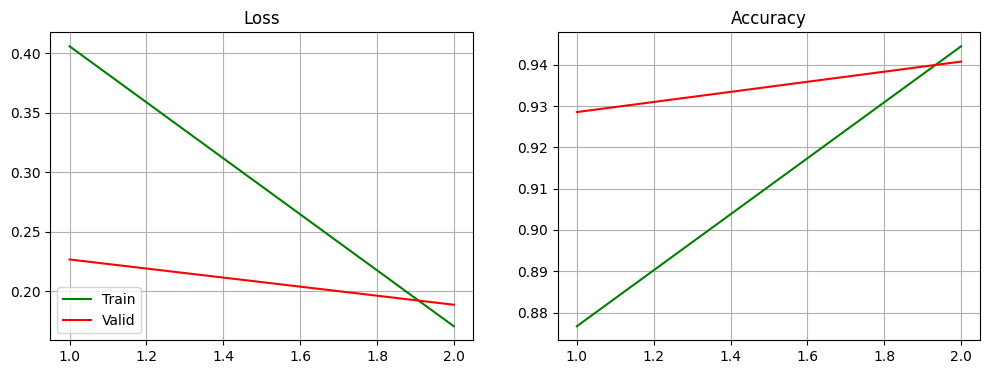

In [10]:
tl_history = process_and_display(history)
model.save_weights('checkpoints_resnet50v2/transfer_learning')

### Fine tuning

In [30]:
len(model.layers)

192

In [11]:
model.layers[165].get_config()['name']

'conv5_block1_out'

In [12]:
setup_to_finetune(model, args, not_trainable=165)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 1,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

507/507 [==============================] - 78s 140ms/step - loss: 0.2035 - accuracy: 0.9355 - val_loss: 0.1205 - val_accuracy: 0.9628


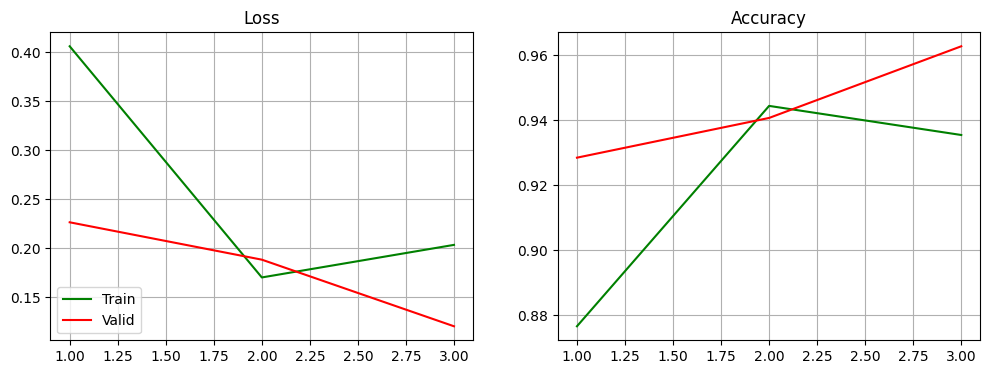

In [13]:
ft126_history = process_and_display(history, tl_history)
model.save_weights('checkpoints_resnet50v2/fine_tuning_165')

In [14]:
model.layers[153].get_config()['name']

'conv4_block6_out'

In [15]:
setup_to_finetune(model, args, not_trainable=153)

history = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 1,
    validation_data=validation_generator,
    validation_steps = valid_steps,
)

507/507 [==============================] - 89s 157ms/step - loss: 0.1857 - accuracy: 0.9403 - val_loss: 0.1338 - val_accuracy: 0.9526


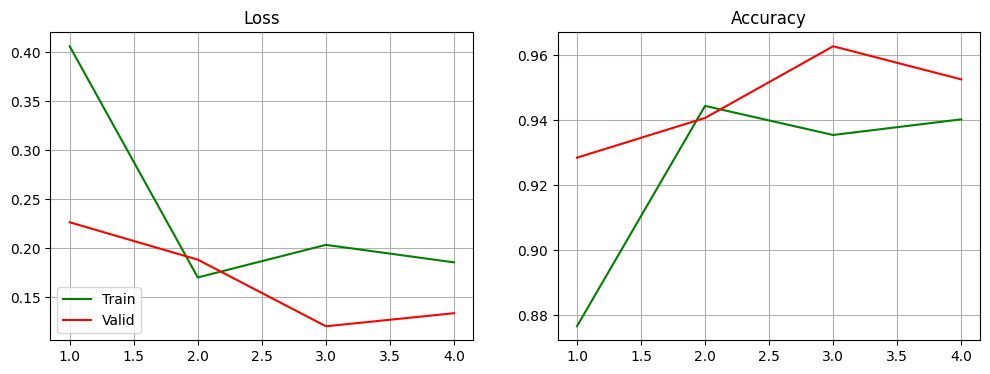

In [16]:
ft116_history = process_and_display(history, tl_history)
model.save_weights('checkpoints_resnet50v2/fine_tuning_153')

In [17]:
model.load_weights('checkpoints_resnet50v2/fine_tuning_153')
model.save('checkpoints_resnet50v2/final')

INFO:tensorflow:Assets written to: checkpoints_resnet50v2/final/assets


INFO:tensorflow:Assets written to: checkpoints_resnet50v2/final/assets


# Final model

## Test scores

In [19]:
from tensorflow.keras.models import load_model
model = load_model('checkpoints_resnet50v2/final')

In [ ]:
nb_test_samples = get_files_count(args.test_dir)
test_steps = int (nb_test_samples / args.batch_size)
model.evaluate(test_generator, steps=test_steps)

 92/168 [===============>..............] - ETA: 7s - loss: 0.1261 - accuracy: 0.9592

## Example results

In [47]:
from keras.preprocessing import image
def findnth(string, substring, n):
    parts = string.split(substring, n + 1)
    if len(parts) <= n + 1:
        return -1
    return len(string) - len(parts[-1]) - len(substring)

def predict(image_path, classes):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img = tf.keras.preprocessing.image.load_img(image_path)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    img_preprocessed = preprocess_input(input_arr)
    predictions = model.predict(img_preprocessed)

    ordered_predictions = [np.argsort(np.max(predictions, axis=0))[-i] for i in range(1, 6)]

    print("Image predictions:")
    for i in range(5):
        print("{}. {} - {:.4f}".format(i+1, classes[ordered_predictions[i]], np.round(predictions[0][ordered_predictions[i]], 4)))

    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 23ms/step
Image predictions:
1. Forest - 1.0000
2. PermanentCrop - 0.0000
3. Highway - 0.0000
4. HerbaceousVegetation - 0.0000
5. River - 0.0000


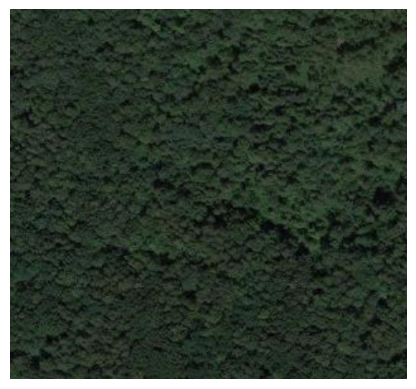

In [48]:
image_path1 = './data/manual_test/1.png'
predict(image_path1, classes)

1/1 [==============================] - 0s 22ms/step
Image predictions:
1. AnnualCrop - 0.9130
2. PermanentCrop - 0.0870
3. SeaLake - 0.0000
4. Highway - 0.0000
5. River - 0.0000


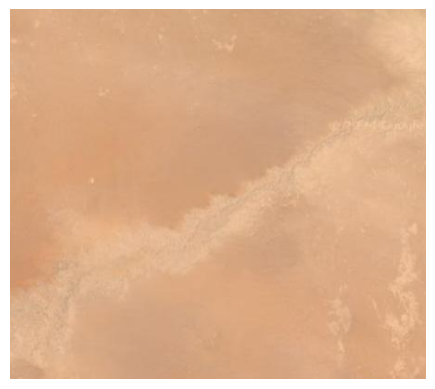

In [49]:
image_path2 = './data/manual_test/2.png'
predict(image_path2, classes)

1/1 [==============================] - 0s 21ms/step
Image predictions:
1. Highway - 1.0000
2. River - 0.0000
3. Industrial - 0.0000
4. HerbaceousVegetation - 0.0000
5. PermanentCrop - 0.0000


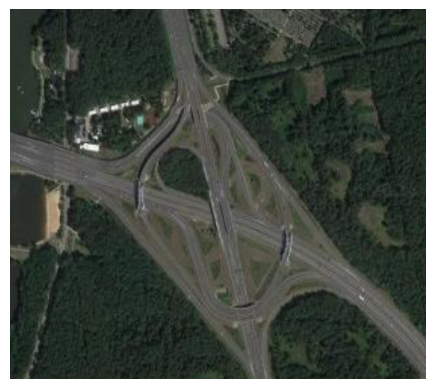

In [50]:
image_path3 = './data/manual_test/3.png'
predict(image_path3, classes)

1/1 [==============================] - 0s 22ms/step
Image predictions:
1. Industrial - 0.9992
2. Highway - 0.0008
3. Residential - 0.0000
4. PermanentCrop - 0.0000
5. River - 0.0000


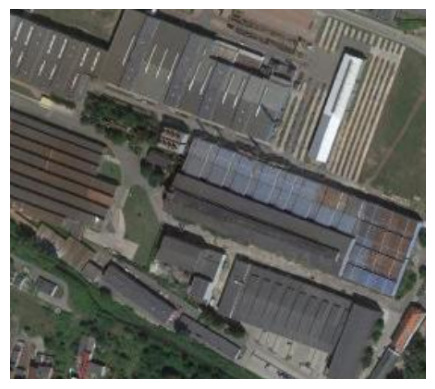

In [51]:
image_path4 = './data/manual_test/4.png'
predict(image_path4, classes)

1/1 [==============================] - 0s 28ms/step
Image predictions:
1. Industrial - 0.9998
2. Highway - 0.0002
3. River - 0.0000
4. Residential - 0.0000
5. PermanentCrop - 0.0000


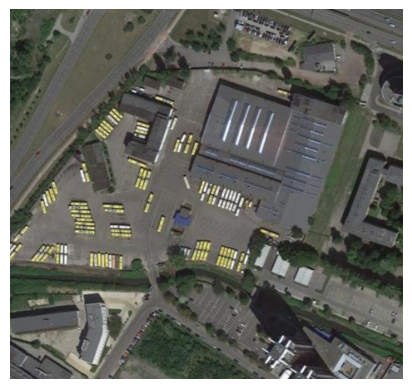

In [52]:
image_path5 = './data/manual_test/5.png'
predict(image_path5, classes)

1/1 [==============================] - 0s 24ms/step
Image predictions:
1. River - 0.6739
2. Residential - 0.1651
3. Highway - 0.1216
4. Industrial - 0.0286
5. PermanentCrop - 0.0056


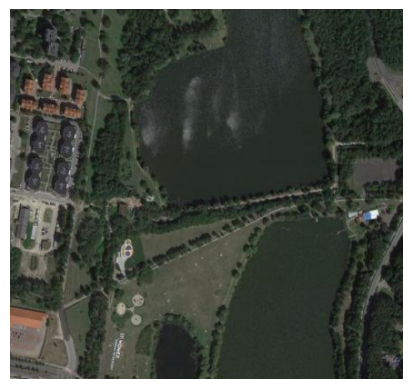

In [53]:
image_path6 = './data/manual_test/6.png'
predict(image_path6, classes)

1/1 [==============================] - 0s 23ms/step
Image predictions:
1. Highway - 0.9818
2. Industrial - 0.0175
3. Residential - 0.0005
4. River - 0.0002
5. PermanentCrop - 0.0000


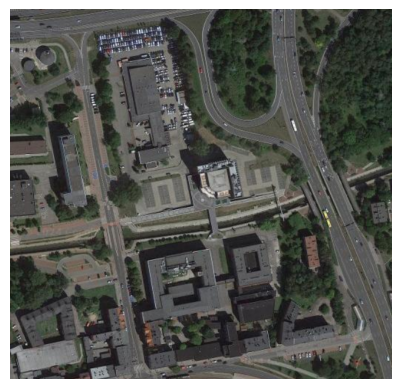

In [54]:
image_path7 = './data/manual_test/7.png'
predict(image_path7, classes)

1/1 [==============================] - 0s 22ms/step
Image predictions:
1. Residential - 0.9639
2. Highway - 0.0171
3. PermanentCrop - 0.0110
4. HerbaceousVegetation - 0.0044
5. Industrial - 0.0020


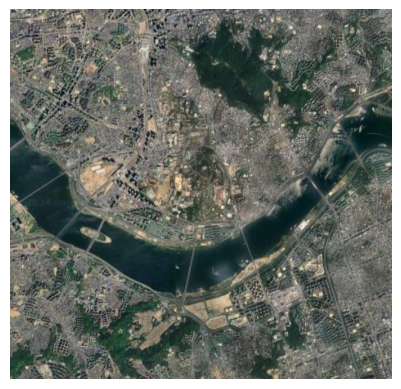

In [55]:
image_path8 = './data/manual_test/8.png'
predict(image_path8, classes)

1/1 [==============================] - 0s 21ms/step
Image predictions:
1. HerbaceousVegetation - 0.9985
2. Pasture - 0.0006
3. PermanentCrop - 0.0005
4. Highway - 0.0003
5. Industrial - 0.0000


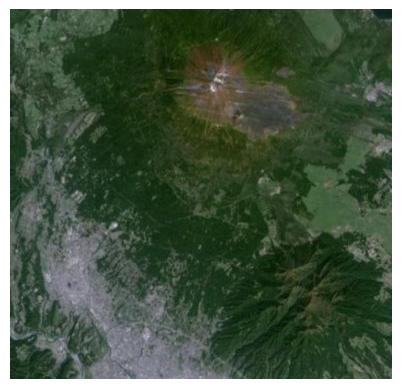

In [56]:
image_path9 = './data/manual_test/9.png'
predict(image_path9, classes)

1/1 [==============================] - 0s 21ms/step
Image predictions:
1. HerbaceousVegetation - 0.7397
2. River - 0.2139
3. Highway - 0.0254
4. Pasture - 0.0125
5. PermanentCrop - 0.0047


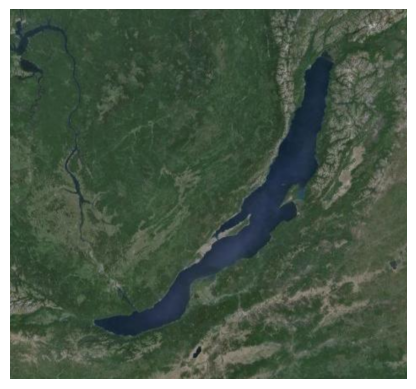

In [57]:
image_path10 = './data/manual_test/10.png'
predict(image_path10, classes)

1/1 [==============================] - 0s 24ms/step
Image predictions:
1. HerbaceousVegetation - 0.3909
2. River - 0.3572
3. Pasture - 0.1085
4. Highway - 0.0617
5. Residential - 0.0385


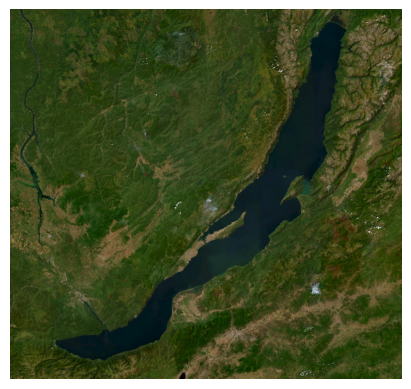

In [58]:
image_path11 = './data/manual_test/11.png'
predict(image_path11, classes)

1/1 [==============================] - 0s 32ms/step
Image predictions:
1. AnnualCrop - 0.8237
2. SeaLake - 0.1762
3. PermanentCrop - 0.0001
4. River - 0.0000
5. Highway - 0.0000


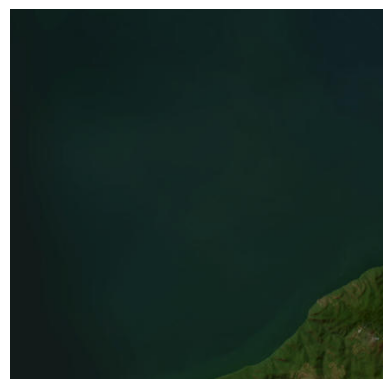

In [59]:
image_path12 = './data/manual_test/12.png'
predict(image_path12, classes)